In [1]:
try:
    from sklearnex import patch_sklearn, unpatch_sklearn
    patch_sklearn()
except:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def set_holiday(takamatsu, year_from = "2017", year_to = "2020"):
    holiday = pd.read_csv(
    'data/syukujitsu.csv',
    skiprows=1,
    names=['DATE', 'HOLIDAY-NAME'],
    parse_dates={'date': ['DATE']},
    index_col = "date",
    encoding='cp932')

    holiday["holiday"] = holiday.index

    from_ = "{}-01-01".format(year_from)
    to_ = "{}-12-31".format(year_to)
    holiday_year = holiday.loc[from_: to_,"holiday"]

    for hly in holiday_year:
        # 祝日を日曜日(6)に設定する
        ymd = pd.to_datetime(hly)
        takamatsu.loc[ymd.strftime('%Y-%m-%d'),["dayofweek"]]=6.0

    return takamatsu.dropna()

説明変数 = temperature, sunhour1, sunhour2, insolation, month, hour, dayofweek
訓練スコア = 0.845466, 検証スコア = 0.842227


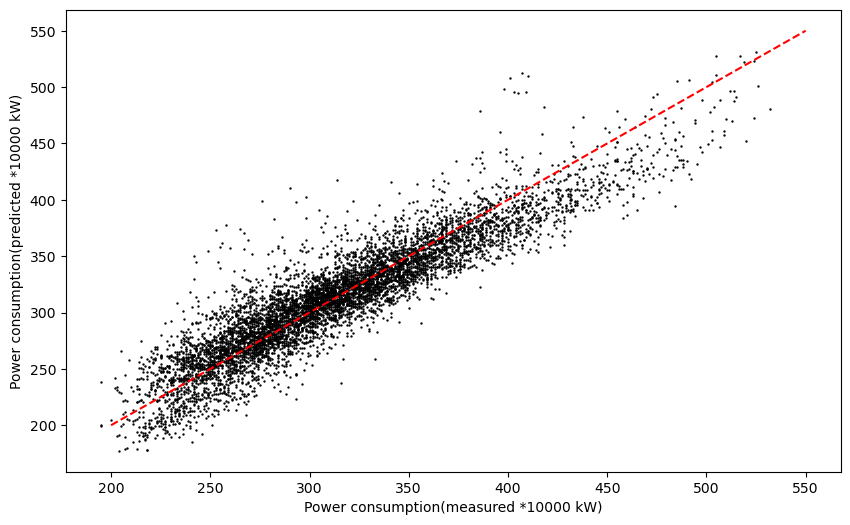

In [3]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 四国電力の電力消費量データを読み込み
ed = [pd.read_csv(
    'data/juyo_shikoku_{:d}.csv'.format(year),
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col = "date_hour")
    for year in [2017, 2018, 2019, 2020]
]
elec_data = pd.concat(ed)

# 複数年の気象データを読み込み
tp = [pd.read_csv(
    './data/takamatsu{:d}.csv'.format(year),
    skiprows=5,
    names=['DATETIME', 'temperature', 'temperature2', 'temperature3', 
           'sunhour1','sunhour2','sunhour3','sunhour4',
           'insolation','insolation2','insolation3',
           'humid','humid2','humid3'],
    parse_dates={'date_hour': ["DATETIME"]},
    index_col='date_hour')
    for year in [2017, 2018, 2019, 2020]
]

tmp = pd.concat(tp)

# 月, 日, 時の取得
tmp["month"] = tmp.index.month
tmp['day'] = tmp.index.day
tmp['dayofyear'] = tmp.index.dayofyear
tmp['hour'] = tmp.index.hour
tmp['dayofweek'] = tmp.index.dayofweek

# 気象データと電力消費量データをいったん統合して時間軸を合わせたうえで、再度分割
#variable = ["temperature","sunhour1","month","hour"]
variable = ["temperature","sunhour1","sunhour2","insolation","month","hour","dayofweek"]
# variable = ["temperature","month","hour","dayofweek"]


# takamatsu_wthr = elec_data.join(tmp[variable]).dropna()
takamatsu_tmp = elec_data.join(tmp[variable]).dropna()
takamatsu_wthr = set_holiday(takamatsu_tmp)

dmy_dayofweek =pd.get_dummies( takamatsu_wthr['dayofweek'], prefix='dwk',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_dayofweek], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('dayofweek',axis=1)

dmy_hour =pd.get_dummies( takamatsu_wthr['hour'], prefix='h',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_hour], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('hour',axis=1)

dmy_month =pd.get_dummies( takamatsu_wthr['month'], prefix='m',prefix_sep='_',drop_first=True)
takamatsu_wthr = pd.concat([takamatsu_wthr,dmy_month], axis=1)
takamatsu_wthr = takamatsu_wthr.drop('month',axis=1)

takamatsu_elec = takamatsu_wthr.pop("consumption")

# from sklearn.preprocessing import PolynomialFeatures
# pf = PolynomialFeatures(degree=3, include_bias=False)
# takamatsu_wthr = pf.fit_transform(takamatsu_wthr)
# takamatsu_wthr = pd.DataFrame(takamatsu_wthr, columns=pf.get_feature_names_out())
takamatsu_wthr["temp2"] = takamatsu_wthr["temperature"]**2
takamatsu_wthr["temp3"] = takamatsu_wthr["temperature"]**3
takamatsu_wthr["sun1x"] = takamatsu_wthr["sunhour1"]**2
takamatsu_wthr["sun2x"] = takamatsu_wthr["sunhour2"]**2
takamatsu_wthr["insolation2"] = takamatsu_wthr["insolation"]**2


# 学習と性能の評価
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

model = LinearRegression()
# model = Ridge(random_state = 0, alpha = 0.01)
# 学習データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(
    takamatsu_wthr, takamatsu_elec, test_size=0.2,random_state=0
    )


# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
x_train_normed = scaler.fit_transform(x_train)
# テストデータも標準化
x_test_normed = scaler.transform(x_test)

scaler2 = StandardScaler()
y_train_normed = scaler2.fit_transform(pd.DataFrame(y_train))
y_test_normed = scaler2.transform(pd.DataFrame(y_test))

model.fit(x_train_normed, y_train_normed.ravel())

score = "説明変数 = {}\n訓練スコア = {:f}, 検証スコア = {:f}".format(
          ", ".join(variable),
          model.score(x_train_normed, y_train_normed),
          model.score(x_test_normed, y_test_normed)
          )

print (score)

# -- 可視化 --
# 画像のサイズを設定する
plt.figure(figsize=(10, 6))

predicted = model.predict(x_test_normed)

plt.xlabel('Power consumption(measured *10000 kW)')
plt.ylabel('Power consumption(predicted *10000 kW)')
plt.scatter(scaler2.inverse_transform(y_test_normed), scaler2.inverse_transform(predicted.reshape(-1,1)), s=0.5, color="black")
plt.plot([200, 550], [200, 550], 'r--')

#plt.savefig("predict-power-consumption-graph.png")
plt.show()


In [4]:
# modelの保存
import joblib

filename ='weather-elec-holiday.pkl'
joblib.dump(model, open(filename, 'wb'))

# Scaleの保存
fname = "scaler.pkl"
joblib.dump(scaler, open(fname, 'wb'))
fname = "scaler2.pkl"
joblib.dump(scaler2, open(fname, 'wb'))

## Ridgeモデルで定数(alpha)を0.01〜10にして学習・テスト

In [5]:
from sklearn.linear_model import Ridge # モジュールインポート
# code11-7
maxScore = 0
maxIndex = 0
# range関数により整数列を1～2000生成
for i in range(1, 2001):
    num = i/100
    ridgeModel = Ridge(random_state = 0, alpha = num)
    ridgeModel.fit(x_train_normed, y_train_normed)
    result = ridgeModel.score(x_test_normed, y_test_normed)
    if result > maxScore:
        maxScore = result
        maxIndex = num

print(maxIndex, maxScore)

0.01 0.8422269773595119


## Lassoモデルで学習・テスト
非線形データに対するLasso回帰モデルの精度は低いことがわかります。

In [6]:
# code11-9
from sklearn.linear_model import Lasso

# x_train, x_test, y_train, y_test = train_test_split(pf_x,
#     sc_t, test_size = 0.3, random_state = 0)

# ラッソ回帰のモデル作成（alphaは正則化項につく定数）
model = Lasso(alpha = 0.1)
model.fit(x_train_normed, y_train_normed)

print(model.score(x_train_normed, y_train_normed)) # 訓練データの決定係数
print(model.score(x_test_normed, y_test_normed)) # テストデータの決定係数

0.43963700622088664
0.438972619960761
